In [8]:
import math
import pickle

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error 

In [9]:
import mlflow 

mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-experiment')


<Experiment: artifact_location='/workspaces/mlops-zoomcamp/module-2/mlruns/1', creation_time=1746881851663, experiment_id='1', last_update_time=1746881851663, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [10]:
# Function that does everythin above: Can be used for validation dataset

def process_dataset(path):
    df = pd.read_parquet(path)
    df = df[df.trip_type == 2]
    
    # Calculate duration
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    
    # Convert datetime to minutes
    df.duration = df.duration.apply(lambda x: x.total_seconds()/60.0)

    #categorical = ['VendorID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type']
    categorical = ['PULocationID', 'DOLocationID']
    numerical = ['trip_distance']

    df = df[(df.duration >= 1) & (df.duration <= 60)]
    df[categorical] = df[categorical].astype(str)

    
    return df

In [11]:
df_train = process_dataset('data/green_tripdata_2021-01.parquet')
df_val = process_dataset('data/green_tripdata_2021-02.parquet')

In [12]:
df_train['PO_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PO_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

### Train model

Training Pipeline

Train RMSE: 3.4110397358269813
Val RMSE: 8.353710401254386


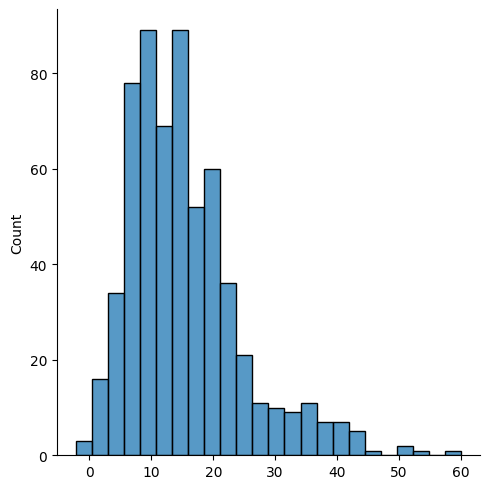

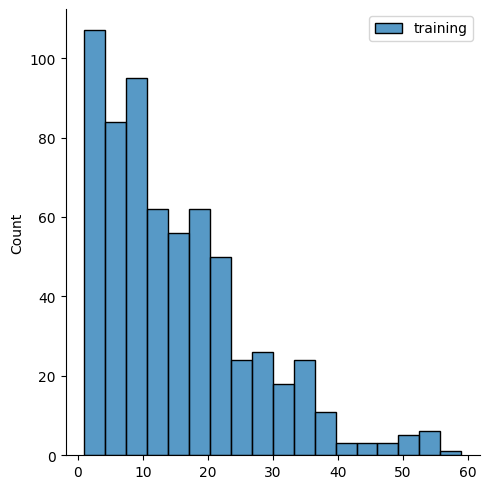

In [13]:
#categorical = ['VendorID', 'store_and_fwd_flag', 'RatecodeID', 'payment_type', 'trip_type']
categorical = ['PO_DO'] #['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()  # Turns a dictionary into vector

train_dicts= df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_train)
print(f'Train RMSE: {math.sqrt(mean_squared_error(y_train, y_pred))}')

y_pred = linear_model.predict(X_val)
print(f'Val RMSE: {math.sqrt(mean_squared_error(y_val, y_pred))}')


# Visualize predictions
sns.displot(y_pred, label='predictions')
sns.displot(y_train, label='training')
plt.legend()

 Model is wrong on average by 4.8 minutes, on validation its nealy 8 minutes.

Try Lasso

In [14]:
# Use Lasso regression: Linear regression with regularization

model = Lasso(alpha=0.0001)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

math.sqrt(mean_squared_error(y_train, y_pred))

3.4113647507698737

Worse than Linear Regression

In [15]:
#Define new run
with mlflow.start_run():

    # Log all information here

    # Name of developer
    mlflow.set_tag("developer", "omkar")

    # Log parameters including hyperps as well as any other relavant thing that affects model performance.
    mlflow.log_param("train_data_path", "module-2/data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val_data_path", "module-2/data/green_tripdata_2021-02.parquet")

    # Log parameter alpha
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    # Use Lasso regression: Linear regression with regularization

    model = Ridge(alpha=alpha)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_train)

    rmse = math.sqrt(mean_squared_error(y_train, y_pred))

    # Log (track) RMSE
    mlflow.log_metric("RMSE", rmse)

In [16]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, linear_model ), f_out)

### Train xgboost model with mlflow

In [17]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope # to define range

In [18]:
train = xgb.DMatrix(X_train, label=y_train)
val = xgb.DMatrix(X_val, label=y_val)

In [35]:
train.num_row(), val.num_row()

(640, 612)

In [36]:
def objective(params):
    '''
    Parameters:
    params (dict): Hyper parameters for xgboost for current run 
    '''
    with mlflow.start_run():
        mlflow.set_tag('model', 'xgboost')
        mlflow.log_params(params)

        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(val, "val")],
            early_stopping_rounds=50

        )
        y_pred = booster.predict(val)
        rmse = math.sqrt(mean_squared_error(y_val, y_pred))
        mlflow.log_metric('rmse', rmse)

    return {'rmse': rmse, 'status':STATUS_OK}



In [37]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),  # [exp(-3), exp(0)] = [~0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:squared_error',
    'seed': 42
}

In [38]:
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

job exception: [15:13:05] /workspace/src/objective/objective.cc:28: Unknown objective function: `reg:squared_error`
Objective candidate: rank:ndcg
Objective candidate: rank:pairwise
Objective candidate: rank:map
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: reg:quantileerror
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:gamma
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror

Stack trace:
  [bt] (0) /workspaces/mlops-zoomcamp/venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x2a6acc) [0x7c2daeca6acc]
  [bt] (1) /workspaces/mlops-zoomcamp

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]


XGBoostError: [15:13:05] /workspace/src/objective/objective.cc:28: Unknown objective function: `reg:squared_error`
Objective candidate: rank:ndcg
Objective candidate: rank:pairwise
Objective candidate: rank:map
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: reg:quantileerror
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:gamma
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror

Stack trace:
  [bt] (0) /workspaces/mlops-zoomcamp/venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x2a6acc) [0x7c2daeca6acc]
  [bt] (1) /workspaces/mlops-zoomcamp/venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x8530ae) [0x7c2daf2530ae]
  [bt] (2) /workspaces/mlops-zoomcamp/venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x67c561) [0x7c2daf07c561]
  [bt] (3) /workspaces/mlops-zoomcamp/venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(+0x6875cb) [0x7c2daf0875cb]
  [bt] (4) /workspaces/mlops-zoomcamp/venv/lib/python3.12/site-packages/xgboost/lib/libxgboost.so(XGBoosterBoostedRounds+0x34) [0x7c2daebb41a4]
  [bt] (5) /lib/x86_64-linux-gnu/libffi.so.7(+0x6ff5) [0x7c2e0a4a4ff5]
  [bt] (6) /lib/x86_64-linux-gnu/libffi.so.7(+0x640a) [0x7c2e0a4a440a]
  [bt] (7) /home/codespace/.python/current/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0x13a46) [0x7c2e0a4c7a46]
  [bt] (8) /home/codespace/.python/current/lib/python3.12/lib-dynload/_ctypes.cpython-312-x86_64-linux-gnu.so(+0xd0ca) [0x7c2e0a4c10ca]



Riege not better as well.